# Example: K-meams clustering of a consumer spending behavior dataset
In this example, we will use the K-means clustering algorithm to analyze a consumer behavior dataset. Fill me in.

> __Learning Objectives:__
> 
> By the end of this example, you should be able to:
> Three learning objectives go here.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Data
In this example, we'll work with a [customer spending preferences dataset from Kaggle](https://www.kaggle.com/code/heeraldedhia/kmeans-clustering-for-customer-data?select=Mall_Customers.csv). This dataset was created learning customer segmentation concepts, known as [market basket analysis](https://en.wikipedia.org/wiki/Market_basket). We will use [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) analysis to explore this data.

> __What's in the dataset?__
> 
> Describe the data, the fields, and any relevant information about the dataset here.

We'll load the dataset by calling [the `MyKaggleCustomerSpendingDataset()` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/#VLDataScienceMachineLearningPackage.MyKaggleCustomerSpendingDataset) which returns [a `DataFrame` instance](https://github.com/JuliaData/DataFrames.jl) containing the data. We'll save the data in the `originaldataset::DataFrame` variable.

In [2]:
originaldataset = MyKaggleCustomerSpendingDataset(); # load the dataset

__Hmmm__. We have [categorical fields](https://en.wikipedia.org/wiki/Categorical_variable). Let's remap the `gender::String7` categorical feature, which is a string, to a number, i.e., let `Male = -1` and `Female = 1.` It's much easier to use numbers than categorical data when looking at (and analyzing) this data later. 
> __Note__: the original dataset did not include example shoppers who identified as non-binary. Hence, we transformed the original `gender::String7` field to ${-1,1}$. However, if non-binary shoppers were to enter the dataset, we could map them to a different number, e.g., `0`.

We'll store the revised dataset in [the `dataset::DataFrame` variable](https://github.com/JuliaData/DataFrames.jl).

In [3]:
dataset = let
    treated_dataset = copy(originaldataset);
    transform!(treated_dataset, :gender => ByRow( x-> (x=="Male" ? -1 : 1)) => :gender); # maps gender to -1,1
    treated_dataset 
end;

Ultimately, we need the raw numerical data and not [a `DataFrame` instance](https://dataframes.juliadata.org/stable/), so let's convert the `dataset::DataFrame` instance to the [`D::Matrix` variable](https://docs.julialang.org/en/v1/base/arrays/#Base.Matrix). Note that we select from column `2:end` because we don't need the `id` field in the data.

In [4]:
D = dataset[:,2:end] |> Matrix # build a data matrix, exclude the id column

200×4 Matrix{Int64}:
 -1  19   15  39
 -1  21   15  81
  1  20   16   6
  1  23   16  77
  1  31   17  40
  1  22   17  76
  1  35   18   6
  1  23   18  94
 -1  64   19   3
  1  30   19  72
  ⋮           
  1  32  103  69
 -1  33  113   8
  1  38  113  91
  1  47  120  16
  1  35  120  79
  1  45  126  28
 -1  32  126  74
 -1  32  137  18
 -1  30  137  83

### Constants
Let's set some constants that we'll need in the examples below. See the comment next to the constant for a description of what it is, it's permissible values, etc.

In [5]:
n = nrow(dataset); # how many example data points do we have? (number of shoppers)
m = 4; # number of features of each shopper
maxiter = 20000; # maximum iterations of our K-means
K = 5; # number of clusters. Why do we pick 5?
ϵ = 1e-6; # tolerance for termination. We can set this to whatever we want

Finally, let's set up the color dictionary for the visualizations in the lecture. The keys of the `my_color_dictionary::Dict{Int64,RGB}` dictionary are the cluster indexes, while the values are the colors mapped to that index.

In [6]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#03045e";
my_color_dictionary[2] = colorant"#0077b6";
my_color_dictionary[3] = colorant"#00b4d8";
my_color_dictionary[4] = colorant"#ffc300";
my_color_dictionary[5] = colorant"#e36414";
my_color_dictionary[6] = colorant"#FF0000";

___

## Task 1: Initial visualization and data exploration
What does the consumer shopping data look like? Let's plot different data views to see if there are apparent patterns or groups in the dataset.

> `Unhide` the code block below to see how we plotted the dataset using [the `Plots.jl` package](https://github.com/JuliaPlots/Plots.jl), and particularly the [`scatter(...)` function](https://docs.juliaplots.org/stable/api/#Plots.scatter-Tuple). An initial look at the data (`income` versus `spendingscore`) suggests that there are perhaps at least five groups (clusters) in the data. However, the groupings in other views, e.g., `age` versus `spending score,` are not as apparent.

Specify the horizontal and vertical axes columns. Note the column names of [type `Symbol`](https://docs.julialang.org/en/v1/manual/metaprogramming/#Symbols), a special type unique string.

In [7]:
horizontal_column = :spendingscore; # x-axis {age | income | gender | spendingscore}
vertical_column = :income; # y-axis {age | income | gender | spendingscore}

So what do we see?

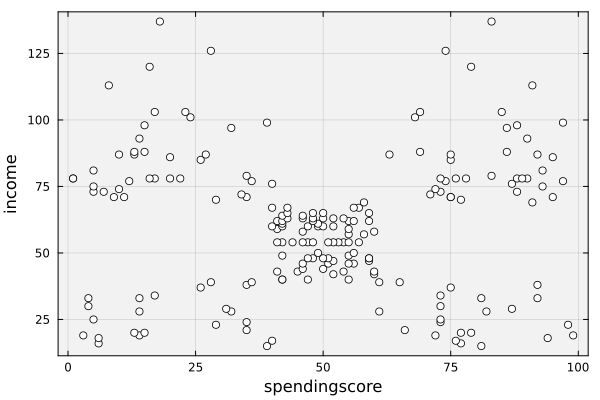

In [8]:
let
    
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot, styled the way we like
    scatter!(dataset[:, horizontal_column], dataset[:, vertical_column], label="", mec=:navy, c=:white)
    xlabel!("$(String(horizontal_column))");
    ylabel!("$(String(vertical_column))");
end

## Task 2: K-means Implementation
In this task, we'll implement the K-means clustering algorithm that we discussed in the lecture. We've developed an [initial K-means implementation using the `cluster(...)` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/clustering/#VLDataScienceMachineLearningPackage.cluster). Let's explore how this implementation performs on our sample dataset. 

> __Buy versus Build__:
> 
> __Why?__ Why are we building our own K-means implementation when there are so many great implementations available? Good question! In practice, you would likely use an existing implementation. There is [already a good clustering package `Clustering.jl` that is available](https://github.com/JuliaStats/Clustering.jl) that exports [a `K-means` function](https://juliastats.org/Clustering.jl/stable/kmeans.html). However, in this demo, we'll use our implementation.
> 
> __Problem model__: Build [a `MyNaiveKMeansClusteringAlgorithm` instance](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/clustering/#VLDataScienceMachineLearningPackage.MyNaiveKMeansClusteringAlgorithm), which holds information about the clustering, i.e., the number of clusters `K::Int,` information about the dataset such as the number of features `m::Int,` and the number of points `n::Int,` and stopping criteria information such as the maximum number of iterations `maxiter::Int` and tolerance `ϵ::Float64`. We'll store this model in the `model::MyNaiveKMeansClusteringAlgorithm` variable.

We build the problem model using [a factory type pattern](https://en.wikipedia.org/wiki/Factory_method_pattern), which uses [a `build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/) to construct and configure a complex object, i.e., set values for the properties on the model that must be computed. The [`build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/) takes the type of thing we want to build as the first argument, and the data required to construct the object (encoded [in a `NamedTupe` type](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple)) as the second argument.

In [ ]:
model = build(MyNaiveKMeansClusteringAlgorithm, (
        maxiter = maxiter,
        dimension = m,
        number_of_points = n,
        K = K,
        ϵ = ϵ,
        scale_factor = 10.0, # scale of the data
));